<a href="https://colab.research.google.com/github/SCS-Technology-and-Innovation/DACS/blob/main/DTDA/coloring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# No interference
## Graph coloring and frequency assignment

Let's revisit the wireless antennas we we placing in the previous module.


When two or more antennas have **overlapping** ranges, their signals will *interfere* with one another. The devices connecting to them will have a hard time communicating when all the signals blend into noise. (This is a physics thing, we do not need the specific details of what happens, why, and how.)

To avoid this, each **neighboring** antenna needs to communicate on a different frequency band.

Let's figure out which of our antennas are neighbors (that is: have overlapping ranges). If all antennas have the same range, then two of them will overlap if and only if the distance between the antennas is less than twice the range.

<img src="https://github.com/SCS-Technology-and-Innovation/DACS/blob/main/DTDA/img/coloring/ranges.png?raw=true" alt="Two non-overlapping antennas">



In [3]:
# REUSING SEVERAL BUILDING BLOCKS FROM THE PREVIOUS SESSION

antennas = [] # empty list
ar = 0.1

size = 600 # make the image this many pixels wide and tall
rangeUnit = ar * size

groundColor = (0, 0, 0) # black
rangeColor = (255, 255, 0) # yellow

from PIL import Image, ImageDraw
# an  image to track the coverage
aux = Image.new('RGB', (size, size), groundColor)
cov = ImageDraw.Draw(aux)

margin = ar / 2 # a margin
span = 1 - 2 * margin # not at the edge of town

threshold = 0.7 # each antenna should cover at least 30% new area
permitted = 100 # give it many more tries
attempts = permitted

margin = ar / 2 # let's not place antennas too close to one another or to the edge of town

def holes(image, background):
  width, height = image.size
  for pixel in image.getdata():
    if pixel == background:
        return True

def coverage(image, background):
  width, height = image.size
  total = width * height
  uncovered = 0
  for pixel in image.getdata():
     if pixel == background:
         uncovered += 1
  return 1 - uncovered / total

from random import random

while holes(aux, groundColor): # still areas to cover
  x = margin + span * random()
  y = margin + span * random()
  pos = (x, y)
  col = size * x
  row = size * y
  bb = (row - rangeUnit, col - rangeUnit, row + rangeUnit, col + rangeUnit)
  zone = aux.crop(bb) # subimage of the bounding box
  present = coverage(zone, groundColor) # what proportion is covered already
  if present < threshold: # cover enough new area
      attempts = permitted
      antennas.append(pos)
      cov.ellipse(bb, fill = rangeColor)
  else: #insignificant
      attempts -= 1 # one less attempt remains
      if attempts == 0:
          break

from math import sqrt # square root

def distance(p1, p2):
  (x1, y1) = p1 # access row and column
  (x2, y2) = p2
  dx = x1 - x2 # subtract to compute how far apart they are
  dy = y1 - y2
  return sqrt(dx**2 + dy**2)

In [4]:
# NEW STUFF for this module

from collections import defaultdict
neighbors = defaultdict(set) # we will record which antennas are neighbors of one another
for antenna in antennas:
  for anotherAntenna in antennas: # check all other antennas
    if antenna != anotherAntenna: # if it is not the same one
      if distance(antenna, anotherAntenna) < 2 * ar: # if it overlaps
        neighbors[antenna].add(anotherAntenna)
        neighbors[anotherAntenna].add(antenna)

for antenna in antennas:
    print(antenna, neighbors.get(antenna, '(no neighbors'))

(0.20638710381960768, 0.1249154970199224) {(0.05119290824198454, 0.0734294776520906), (0.27955622745792935, 0.10654151363935566), (0.05629324400151256, 0.05748540047340472), (0.061436516298419896, 0.10410927336960413), (0.3547538003302194, 0.057287691239754614), (0.13908762209450992, 0.3040567715471579), (0.06123389012125116, 0.05843026463607923), (0.2779326791823269, 0.24729671444034396)}
(0.0635274982085631, 0.6173485382134336) {(0.05761600052043613, 0.7418705456721453), (0.21574535985031057, 0.7164067803685725), (0.13895837104534758, 0.5163185119725187), (0.20893439021809068, 0.5439991550219969), (0.06307494495585798, 0.4237025307108878), (0.09287032956347599, 0.5896734862525133)}
(0.4517448698161612, 0.8428003199307771) {(0.4932852713073974, 0.6563900643674733), (0.4509469958031873, 0.9385314833577386), (0.31821083239986103, 0.9482233953100137), (0.5329151966062452, 0.8821489653237331), (0.36060303723899945, 0.6769407400387603)}
(0.09287032956347599, 0.5896734862525133) {(0.0576160

Okay, that is not very easy to read. Let's give each antenna a label. Call them `1`, `2`, and so forth. Let's draw the antennas as vertices (also called nodes) of a graph (also called a network) and connect each pair of neighbors with a line (called an edge).

There is a good library called `networkx` ([documentation](https://networkx.org/documentation/stable/tutorial.html)) for all this so we can stop thinking about this as an image.

Graph with 61 nodes and 150 edges


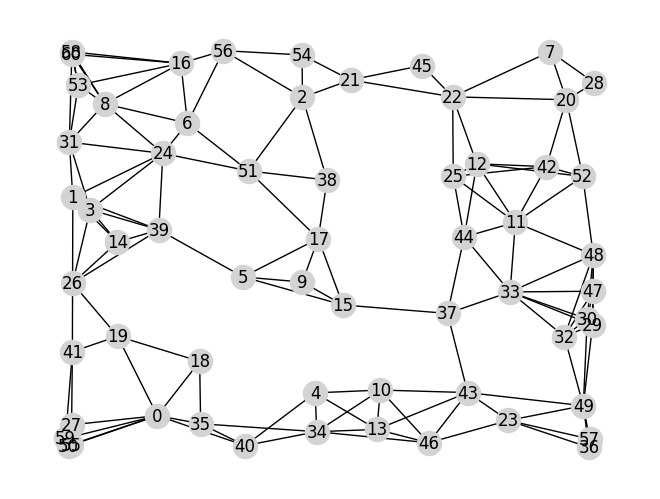

In [5]:
import networkx as nx

graph = nx.Graph()
counter = 0
labels = dict()

for antenna in antennas:
  labels[antenna] = counter
  counter += 1 # make them 0, 1, 2, 3, ...
  graph.add_node(labels[antenna], pos = antenna) # antenna 1 is at position (x, y)

for antenna in antennas:
  a = labels[antenna]
  for neighbor in neighbors[antenna]:
    n = labels[neighbor]
    graph.add_edge(a, n)

print(graph)

coords = nx.get_node_attributes(graph, 'pos')
nx.draw(graph, coords, node_color = 'lightgray')
l = nx.draw_networkx_labels(graph, pos = coords)

Nice, but a bit small. Let's make it larger.

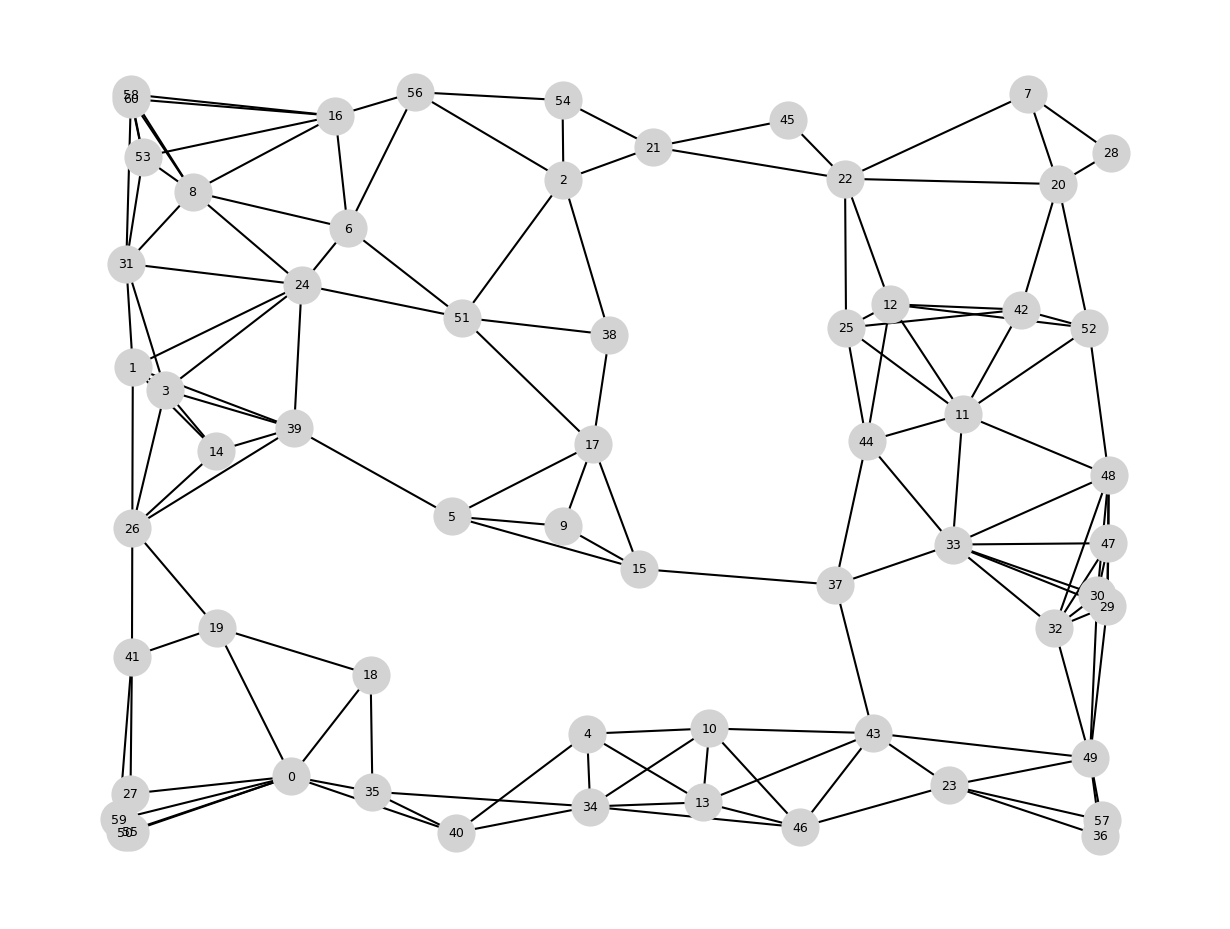

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize = (8, 6), dpi =  150)

nx.draw(graph, coords, node_color = 'lightgray')
l = nx.draw_networkx_labels(graph, pos = coords, font_size = 6)

Now we are all set to start worrying about assigning a different frequency to neighboring antennas. Ideally, we would use the smallest possible amount of different frequencies, but this is a complex problem.

We will represent each frequency with a different *color*. We can look up names of colors for the drawing in the [documentation](https://matplotlib.org/stable/gallery/color/named_colors.html) of the `matplotlib` library.

In *combinatorial optimization*, this problem is called the **graph-coloring problem** and the *objective function* is to **minimize** the total number of colors, whereas the *restriction* is that no neighboring vertices may share a color.

Let's settle for a simple *heuristic* (that is: a strategy to create a solution that does not violate any restrictions while *attempting* to consider the objective function) that may not be *optimal* but attempts to use each color as often as possible

Create a first color and then assign that color to each vertex that can take it (that does not have a neighbor of that color yet) in descending order of their degrees (that is, the number of neighbors they have) until all vertices are examined.

Then create a second color and repeat the examination.

Keep creating colors until every node has been assigned a color.

In [7]:
degrees = [ (vertex, graph.degree(vertex)) for vertex in graph.nodes ]
print('Original order', degrees)

degrees.sort(key = lambda pair : pair[1]) # sort by the second value in each tuple
print('Ascending order', degrees)

degrees.sort(key = lambda pair : -pair[1]) # descending order
print('Descending order', degrees)

Original order [(0, 8), (1, 6), (2, 5), (3, 6), (4, 4), (5, 4), (6, 5), (7, 3), (8, 7), (9, 3), (10, 5), (11, 7), (12, 6), (13, 5), (14, 4), (15, 4), (16, 6), (17, 5), (18, 3), (19, 4), (20, 5), (21, 4), (22, 6), (23, 5), (24, 7), (25, 5), (26, 6), (27, 5), (28, 2), (29, 6), (30, 6), (31, 6), (32, 6), (33, 8), (34, 6), (35, 4), (36, 3), (37, 4), (38, 3), (39, 6), (40, 4), (41, 4), (42, 5), (43, 6), (44, 5), (45, 2), (46, 5), (47, 5), (48, 7), (49, 7), (50, 4), (51, 5), (52, 5), (53, 5), (54, 3), (55, 4), (56, 4), (57, 3), (58, 4), (59, 5), (60, 5)]
Ascending order [(28, 2), (45, 2), (7, 3), (9, 3), (18, 3), (36, 3), (38, 3), (54, 3), (57, 3), (4, 4), (5, 4), (14, 4), (15, 4), (19, 4), (21, 4), (35, 4), (37, 4), (40, 4), (41, 4), (50, 4), (55, 4), (56, 4), (58, 4), (2, 5), (6, 5), (10, 5), (13, 5), (17, 5), (20, 5), (23, 5), (25, 5), (27, 5), (42, 5), (44, 5), (46, 5), (47, 5), (51, 5), (52, 5), (53, 5), (59, 5), (60, 5), (1, 6), (3, 6), (12, 6), (16, 6), (22, 6), (26, 6), (29, 6), (30,

In [8]:
colors = [ 'cyan', 'orange', 'lime', 'violet', 'yellow', 'wheat', 'hotpink' ]
assignment = [ None for vertex in graph.nodes ] # no colors assigned in the beginning

while None in assignment: # while at least one vertex lacks a color
  if len(colors) == 0: # we ran out of colors
    missing = sum( [ a is None for a in assignment ] )
    print(f'Out of colors and {missing} vertices have no color yet')
    break
  current = colors.pop(0) # grab the first color
  for (vertex, degree) in degrees:
   if assignment[vertex] == None: # no color yet
     nc = [ assignment[n] for n in graph.neighbors(vertex) ] # neighbor colors
     if current not in nc: # no neighbor has this color
       assignment[vertex] = current

k = len(colors)
pl = 's' if k > 1 else ''
print(f'Finished with {k} color{pl} left over')

Finished with 1 color left over


Let's draw again but now using the assigned colors.

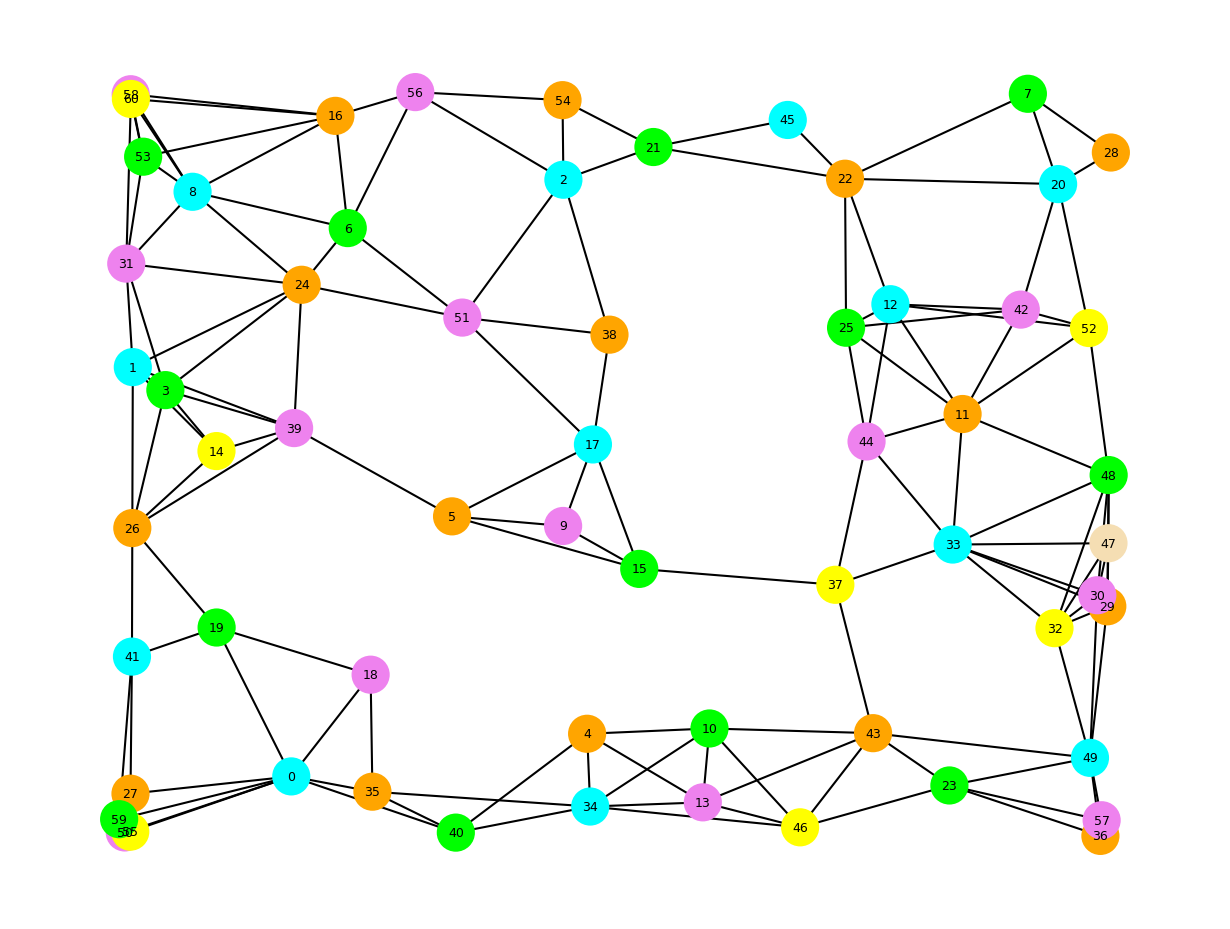

In [9]:
fig = plt.figure(1, figsize = (8, 6), dpi =  150)
nx.draw(graph, coords, node_color = assignment)
l = nx.draw_networkx_labels(graph, pos = coords, font_size = 6)